In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tic_env import TictactoeEnv, OptimalPlayer
from performance_measures import M_opt, M_rand
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display_png, Image
from tqdm.notebook import tqdm
from io import BytesIO
import imageio
plt.style

$M_opt$ measures the performance of $\pi$ against the optimal policy. <br>
To compute $M_{opt}$, we run $\pi$ against `Opt(0)` for `N = 500` games for different random seeds. <br>
$\pi$ makes the 1st move in 250 games, and `Opt(0)` makes the 1st move in the rest. <br>
We count how many games $\pi$ wins ($N_{win}$) and loses ($N_{loss}$) and define $$M_{opt} = \frac{N_{win} - N_{loss}}{N}$$.

$M_{rand}$ measures the performance of against the random policy. <br>
To compute $M_{rand}$, we repeat what we did for computing $M_{opt}$ but by using `Opt(1)` instead of `Opt(0)`.

In [3]:
p = OptimalPlayer(0)
print("M_opt: ", M_opt(p), ", M_rand: ", M_rand(p))

M_opt:  0.0 M_rand 0.918


## Q-Learning combined with epsilon-greedy policy. 

We start by creating a data structure to save our Q values

In [86]:
# stores only one value that it returns on any key
class FinalState():
    def __init__(self):
        self.value = 0
    def __getitem__(self, key):
        return self.value
    def __setitem__(self, key, value):
        self.value = value
    def values(self):
        return [self.value]
    def __repr__(self):
        return "{any: " + str(self.value) + "}"

# Q_table[state][move]
class QTable(dict):
    def __getitem__(self, key):
        self.__check_key(key)
        return super().__getitem__(self.__to_tuple(key))
    def __setitem__(self, key, value):
        self.__check_key(key)
        super().__setitem__(self.__to_tuple(key), value)

    def __missing__(self, key):
        arr = self.__to_array(key)
        non_zero_locations = list(zip(*np.nonzero(arr == 0)))
        if len(non_zero_locations) == 0:
            ret = self[arr] = FinalState()
            return ret
        ret = self[arr] = {loc: 0 for loc in non_zero_locations}
        return ret

    def __check_key(self, key):
        if not isinstance(key, np.ndarray):
            raise(TypeError("QTable only accepts np.ndarray of as keys"))
        if key.shape != (3, 3):
            raise(ValueError("QTable only accepts np.ndarray of shape (3, 3)"))
    def __to_array(self, key):
        if isinstance(key, tuple):
            key = np.array(key).reshape(3, 3)
        return key
    def __to_tuple(self, key):
        if isinstance(key, np.ndarray):
            key = tuple(key.reshape(-1))
        return key

In [97]:
f = FinalState()

At each time $t$, state $s_t$ is the board position, action $a_t$ is one of the available positions on the board and reward $r_t$. <br>
The reward only non-zero when the game ends where you get $r_t = 1$ if you win the game, $r_t = 1$ if you lose, and $r_t=0$ if it is a draw.

Q-Learning has 3 hyper-parameters: 
- learning rate $\alpha$
- discount factor $\gamma$
- and exploration level $\epsilon$ 

For convenience, we fix the learning rate at alpha = 0.05 and the discount factor at $\gamma$ = 0.99. <br>
We initialize all the Q-values at 0. <br>
If you are curious, you can explore the effect of $\alpha$, $\gamma$ and initial Q-values for yourself. <br>

In [92]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon = 0 # exploration rate

### 2.1 Learning from experts

In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against `Opt(`$\epsilon_{opt}$`)` for some $\epsilon_{opt} \in [0; 1]$. <br> 
To do so, implement the Q-learning algorithm. To check the algorithm, run a Q-learning agent, with a fixed and arbitrary $\epsilon_{opt} \in [0; 1)$ against `Opt(0.5)` for 20'000 games. <br> 
Switch the 1st player after every game.

In [93]:
env = TictactoeEnv()
Q_table = QTable()
rewards = []
num_trained_episodes = 0
av_rewards = []

def epslion_greedy(state):
    Q_actions = Q_table[state]
    if np.random.random() < epsilon:
        actions = list(Q_actions.keys())
        if len(actions) == 1:
            return actions[0]
        return actions[np.random.randint(0, len(actions)-1)]
    else:
        return max(Q_actions, key=Q_actions.get)

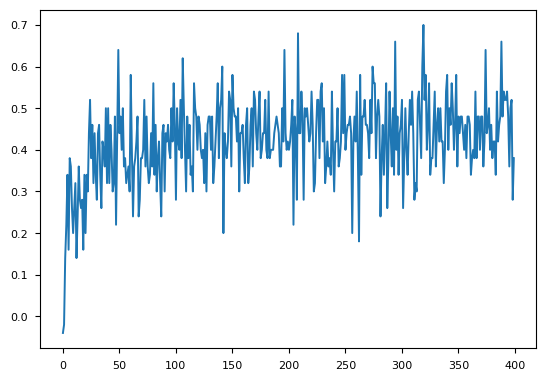

In [94]:
num_episodes = 20000
opponent_player = OptimalPlayer(0.5, player='O')
learning_player = 'X'
rewards = []

for itr in tqdm(range(num_episodes), desc="Q-learning"):
    env.reset()
    state, end, _ = env.observe()

    opponent_player.player, learning_player = learning_player, opponent_player.player

    if opponent_player.player == 'X':
        opponent_move = opponent_player.act(state)
        state, end, _ = env.step(opponent_move)

    while not end:
        move = epslion_greedy(state)
        next_state, end, _ = env.step(move)

        if (not end) and (env.current_player == opponent_player.player):
            opponent_move = opponent_player.act(next_state)
            next_state, end, _ = env.step(opponent_move)
        
        reward = env.reward(player=learning_player)
            
        if end:
            Q_table[next_state]["any"] = reward
        
        Q_table[state][move] = Q_table[state][move] + alpha * (reward + gamma * max(Q_table[next_state].values()) - Q_table[state][move])

        state = next_state

    rewards.append(reward)
    if len(rewards) >= 50:
        av_rewards.append(np.mean(rewards))
        rewards = []
        clear_output(wait=True)
        plt.plot(av_rewards)
        plt.show()
    num_trained_episodes += 1
    env.reset()

In [90]:
print("M_opt: ", M_opt(epslion_greedy), ", M_rand: ", M_rand(epslion_greedy))

M_opt:  -0.016 , M_rand:  0.764


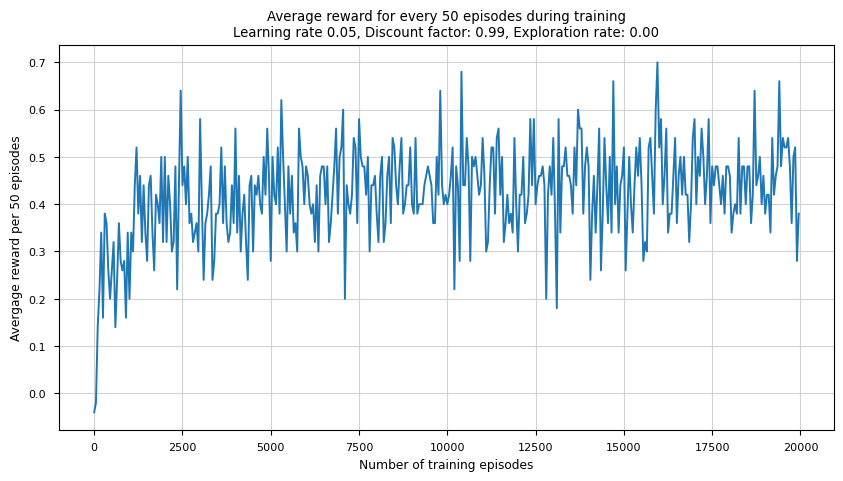

In [95]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_trained_episodes, 50), av_rewards, "-")
plt.title(f"Average reward for every 50 episodes during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f}, Exploration rate: {epsilon:.2f}")
plt.ylabel("Avergage reward per 50 episodes")
plt.xlabel("Number of training episodes")
plt.grid(color="lightgrey")
plt.show()

### 2.1.1 Decreasing exploration

One way to make training more efficient is to decrease the exploration level $\epsilon$ over time. If we define $\epsilon(n)$ to be $\epsilon$ for game number $n$, then one feasible way to decrease exploration during training is to use
$$
\epsilon(n)=\max \left\{\epsilon_{\min }, \epsilon_{\max }\left(1-\frac{n}{n^{*}}\right)\right\}
$$
where $\epsilon_{\min }$ and $\epsilon_{\max }$ are the minimum and maximum values for $\epsilon$, respectively, and $n^{*}$ is the number of exploratory games and shows how fast $\epsilon$ decreases. For convenience, we assume $\epsilon_{\min }=0.1$ and $\epsilon_{\max }=0.8$; if you are curious, you can explore their effect on performance for yourself. Use $\epsilon(n)$ as define above and run different $Q$-learning agents with different values of $n^{*}$ against Opt (0.5) for 20 '000 games - switch the 1st player after every game. Choose sevpral values of $n^{*}$ from a reasonably wide interval between 1 to $40^{\prime} 000$ - particularly, include $n^{*}=1$.


In [104]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon = 0 # exploration rate

In [ ]:
env = TictactoeEnv()
Q_table = QTable()
rewards = []
num_trained_episodes = 0
av_rewards = []

def epslion_greedy(state):
    Q_actions = Q_table[state]
    if np.random.random() < epsilon:
        actions = list(Q_actions.keys())
        if len(actions) == 1:
            return actions[0]
        return actions[np.random.randint(0, len(actions)-1)]
    else:
        return max(Q_actions, key=Q_actions.get)

In [ ]:
num_episodes = 20000
opponent_player = OptimalPlayer(0.5, player='O')
learning_player = 'X'
rewards = []

for itr in tqdm(range(num_episodes), desc="Q-learning"):
    env.reset()
    state, end, _ = env.observe()

    opponent_player.player, learning_player = learning_player, opponent_player.player

    if opponent_player.player == 'X':
        opponent_move = opponent_player.act(state)
        state, end, _ = env.step(opponent_move)

    while not end:
        move = epslion_greedy(state)
        next_state, end, _ = env.step(move)

        if (not end) and (env.current_player == opponent_player.player):
            opponent_move = opponent_player.act(next_state)
            next_state, end, _ = env.step(opponent_move)
        
        reward = env.reward(player=learning_player)
            
        if end:
            Q_table[next_state]["any"] = reward
        
        Q_table[state][move] = Q_table[state][move] + alpha * (reward + gamma * max(Q_table[next_state].values()) - Q_table[state][move])

        state = next_state

    rewards.append(reward)
    if len(rewards) >= 50:
        av_rewards.append(np.mean(rewards))
        rewards = []
        clear_output(wait=True)
        plt.plot(av_rewards)
        plt.show()
    num_trained_episodes += 1
    env.reset()